<a href="https://colab.research.google.com/github/nbchan/INMR96-Digital-Health-and-Data-Analytics/blob/main/Week_07_Natural_Language_Processing_in_Healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing (NLP) in Healthcare

NLP is a branch of data analytics that focuses on understanding and interpreting **human language** using computational techniques. It involves algorithms and models designed to process, analyze, and derive meaning from **text and speech data**, as opposed to typical structured tabular data. Clinical notes are the most common form of such kind of data in the context of healthcare.

Clinical notes are available in MIMIC-III. You can assess the clinical notes included in MIMIC-III by either (i) navigating to the database called `physionet-data.mimiciii_notes` (instead of the usual `physionet-data.mimiciii_clinical`)  on [Google BigQuery](https://console.cloud.google.com/bigquery) and look of the table called `noteevents`; or (ii) directly downloading the file named `NOTEEVENTS.csv.gz` on the [MIMIC-III project page](https://physionet.org/content/mimiciii/1.4/). However, we will be using another simpler dataset for this demo.

---

# 1. Background and Objectives

**Dataset Description**

We will be using the [Drug Review Dataset](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29) for this code demonstration, which is inspired by a paper that used the same dataset (see citation below). The dataset provides patient reviews on specific drugs along with their related conditions and a 10-star patient rating reflecting their overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites.

The objective of this notebook is to build a model that predicts whether a drug review is positive or not by utilising NLP.

**Dataset Split**

The data is split into a train (75%) and a test (25%) partition (see publication) and stored in two .tsv (tab-separated-values) files, respectively.

**Dataset Description**

|  | Column Name | Data Type | Description |
|---|---|---|---|
| 1 | drugName | categorical | name of drug |
| 2 | condition | categorical | name of condition |
| 3 | review | **_text_** | patient review |
| 4 | rating | numeric | patient rating ranging from 1 to 10 |
| 5 | date | date | date of review entry |
| 6 | usefulCount | numeric | number of users who found the review useful |

**Citation**

Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125.

---

# 2. Setting up

**Data Imoprt**

In [ ]:
# Set up our base working folder to data import.
work_path = "/content"
print(work_path)

/content


In [ ]:
# Download the compressed dataset to our Colab runtime.
# If you wish to download it to your Google Drive instead, you would have to
# grant Colab access to your Google Drive like what we have done in previous
# sessions.
!wget -P $work_path https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip

--2024-02-26 15:20:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/content/drugsCom_raw.zip’

drugsCom_raw.zip        [       <=>          ]  41.00M  29.1MB/s    in 1.4s    

2024-02-26 15:20:40 (29.1 MB/s) - ‘/content/drugsCom_raw.zip’ saved [42989872]



In [ ]:
# Uncompress the raw data into the base folder by using the python
# package zipfile. Doing so would create two files in the folder:
# `drugsComTrain_raw.tsv` and `drugsComTest_raw.tsv`
import os
from zipfile import ZipFile

# Load the drugom_raw.zip file and create a zip object, which will
# be used to unzip the raw data.
with ZipFile(os.path.join(work_path, "drugsCom_raw.zip"), 'r') as zo:
  # Extract specific file in the zip into our base folder.
  zo.extractall(path=work_path)

  # It is always recommended to close the zip object after the unzip progress
  # to free up memory.
  zo.close()

In [ ]:
# Have a look at what we have under this folder.
# Note that `drugsComTrain_raw.tsv` and `drugsComTest_raw.tsv` are on the list,
# meaning we have successfully extracted the compressed data.
!ls -al $work_path

total 151732
drwxr-xr-x 1 root root     4096 Feb 26 15:23 .
drwxr-xr-x 1 root root     4096 Feb 26 15:19 ..
drwxr-xr-x 4 root root     4096 Feb 22 14:24 .config
-rw-r--r-- 1 root root 42989872 Feb 26 15:20 drugsCom_raw.zip
-rw-r--r-- 1 root root 28071166 Feb 26 15:23 drugsComTest_raw.tsv
-rw-r--r-- 1 root root 84289175 Feb 26 15:23 drugsComTrain_raw.tsv
drwxr-xr-x 1 root root     4096 Feb 22 14:24 sample_data


In [ ]:
import pandas as pd

In [50]:
# Read in the raw `drugsComTrain_raw.tsv` file into a pandas DataFrame.
df_train = pd.read_csv(os.path.join(work_path, "drugsComTrain_raw.tsv"), sep="\t")

In [51]:
# Print the size of the train set, and have a look at it to make sure the import was successful.
print(df_train.shape)
df_train

(161297, 7)


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10.0,"May 31, 2015",125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1.0,"November 1, 2011",34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2.0,"March 15, 2014",35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10.0,"September 19, 2015",79


<Axes: >

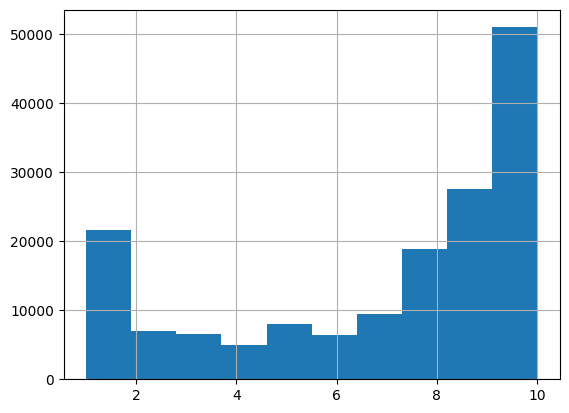

In [52]:
# Having the quick look of the distribution of the "rating" column
df_train['rating'].hist()

In [53]:
# Read the `drugsComTest_raw.tsv` file into a pandas DataFrame as our test set.
df_test = pd.read_csv(os.path.join(work_path, "drugsComTest_raw.tsv"), sep="\t")

In [54]:
# Have a glimpse of the test dataset.
print(df_test.shape)
df_test

(53766, 7)


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20


---

# 3. Creating our Training and Testing Sets


## 3.1. Subsetting the data

The original dataset is rather large (161,297 training samples and 53,766 testing samples). For illustrative purposes in this demo, we would only include 800 and 200 training and testing samples respectively to speed things up.


In [55]:
# Drop all columns except for `review` and `rating` for the training set.
# Randomly select a small portion into our train data, say 800.
df_train = df_train[['review', 'rating']]
df_train = df_train.sample(n=800, random_state=1)

In [56]:
# Reset the index.
df_train = df_train.reset_index(drop=True)

In [57]:
# Print the sub train set information.
print(df_train.shape)
df_train

(800, 2)


,review,rating
0,"""This was my first pill I have ever tried, and...",1.0
1,"""Hi there,\r\n\r\nI also wanted to write a pos...",10.0
2,"""I&#039;m basically a very hard sell when it c...",10.0
3,"""My son is 5 1/2. We&#039;ve always noticed hi...",8.0
4,"""I&#039;ve had it about 2 months now, and my e...",10.0
...,...,...
795,"""I completely stopped having panic attacks aft...",8.0
796,"""I&#039;m 23, never given birth, had it insert...",6.0
797,"""I had Implanon for 3 years now. It&#039;s tim...",10.0
798,"""Simply wonderful. I took 20 mg for the first ...",9.0


In [58]:
from IPython.display import HTML, display

Here is an example of a review with rating "1":

In [59]:
display(HTML(df_train.loc[0]['review']))

And here is an example of a review with rating "10":

In [60]:
display(HTML(df_train.loc[2]['review']))

In [61]:
# Drop columns in the test set except for review and rating like the train set.
# Here only 200 records are chosen at random into the test set.
# Also the index would be reset.
df_test = df_test[['review', 'rating']]
df_test = df_test.sample(n=200, random_state=1)
df_test = df_test.reset_index(drop=True)

In [62]:
# Print the sub-test set.
print(df_test.shape)
df_test

(200, 2)


,review,rating
0,"""I turned into a total zombie on this. Litera...",1.0
1,"""I took this yesterday after a whole night wit...",10.0
2,"""I have been on Latuda 80mg for almost 2 month...",1.0
3,"""I have been taking Victoza 1.2mg for about a ...",5.0
4,"""I started Siliq 6 months ago at 90 % body cov...",10.0
...,...,...
195,"""I took this pill next day after having unprot...",10.0
196,"""I&#039;ve loved Nexplanon. The insertion was ...",10.0
197,"""I receive the highest dose of this drug for s...",8.0
198,"""I absolutely hate this medication. I had cold...",1.0


## 3.2. Transform the `rating` column into a binary variable

Here, we transform the prediction outcome into a binary variable to simplify it a bit, which changes our final model from a regression model into a **classification model**. The binary variable is saved in a new column called `pos_rating`.
If the rating is equal to or greater than 5, set it to 1. Otherwise, set it to 0.

In [65]:
import numpy as np

# Frist, transform the column type of `rating` to int.
# Then, if the rating is equal to or greater than 5, set it to 1.
# Otherwise, set it to 0.
df_train['rating'] = df_train['rating'].apply(np.int64)
df_train['pos_rating'] = df_train['rating'].apply(lambda x: 1 if x >= 5 else 0)

df_test['rating'] = df_test['rating'].apply(np.int64)
df_test['pos_rating'] = df_test['rating'].apply(lambda x: 1 if x >= 5 else 0)

# More about apply and lambda could be found:
# Pandas apply function:
# https://medium.com/analytics-vidhya/no-more-confusion-between-apply-map-and-applymap-f982bb98c099
# https://www.geeksforgeeks.org/difference-between-map-applymap-and-apply-methods-in-pandas/
# Python lambda function:
# https://realpython.com/python-lambda/

In [66]:
# Numbers of rating group by rating.
print("Train set:")
print(df_train['pos_rating'].value_counts())
print()
print("Test set:")
print(df_test['pos_rating'].value_counts())

Train set:
1    608
0    192
Name: pos_rating, dtype: int64

Test set:
1    150
0     50
Name: pos_rating, dtype: int64


In [67]:
# Print the shape of the dataset.
print(f"Train set: {df_train.shape}")
print(f"Test set: {df_test.shape}")

Train set: (800, 3)
Test set: (200, 3)


In [81]:
# Prepare our dataset for vectorization.
X_train, y_train = df_train['review'], df_train['pos_rating']
X_test, y_test = df_test['review'], df_test['pos_rating']

---

# Vectorization

Vectorization is the process of converting data into a format that can be operated on by computers more efficiently. In the context of NLP, vectorization involves representing textual data as numerical vectors (or a series of numbers), making it easier for algorithms to process and analyze.

Likewise, as we cannot use the `review` column (which is in text format) for modelling directly. We need to find ways to convert it into a series of numbers for further computation and modelling, or in other words, to **vectorize** them. Here, we demonstrate two methods to do so (section 4 and 5 below), both using TF-IDF (term frequency-inverse document frequency).


TF-IDF is a simple technique in NLP to understand the relative importance of a word in a document or a collection of documents.

* The TF part (Term Frequency) measures how often a word appears in a document. If a word appears many times in a document, it's likely important.

* The IDF part (Inverse Document Frequency) measures how unique or rare a word is relative to all documents. If a word appears rarely in many documents, it's likely significant. In contrast, if a word appears across multiple documents (e.g. "the", "a", "it"), it's likely insignificant.

Combining these measures, TF-IDF gives higher weight to words that appear often in a document but rarely in other documents. This helps identify the importance of words in distinguishing one document from another.

---

# 4. Option A: Directly Apply TF-IDF to Embed Textual Data

**1. Set up the TF-IDF vectorizer**

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

**2. Perform the TF-IDF vectorization**

In [70]:
# Perform the TF-IDF vectorization.
x_train_tfidf_a = vectorizer.fit_transform(X_train)
x_test_tfidf_a = vectorizer.transform(X_test)

In [71]:
# Check the dimensions of the vectoried dataset.
# Note that there is a total of 5,200 words (features) in our corpus.
print(f"Train set: {x_train_tfidf_a.shape}")
print(f"Test set: {x_test_tfidf_a.shape}")

Train set: (800, 5200)
Test set: (200, 5200)


In [75]:
# A preview of the vectoried results. As there are 5,200 words in our corpus and
# each review only includes a handful of words, most of the entires would be 0,
# indicating no occurence of those words in that specific review.
x_train_tfidf_a.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

---

# 5. Option B: Use NLP-specific Data Preprocessing Steps and TF-IDF to Embed Textual Data

In NLP, data preprocessing aims to clean and prepare text data so that computers can understand and analyze it better. This involves tasks like removing unnecessary information (like punctuation or special characters), converting text to lowercase, and splitting text into individual words or tokens. The goal is to make the text data **consistent and easier** for algorithms to work with, helping them to extract meaningful insights or perform tasks like sentiment analysis or language translation more accurately. Applying these preprocessing steps would also result in a smaller corpus (from 5,200 words to 4,509 in this example).

Let us look at a specific review and see how various NLP steps transform the sentence.

In [76]:
# the original review
X_train[1]

'"Hi there,\r\n\r\nI also wanted to write a positive review. The first few days of having the Copper IUD was difficult. IBprofin became my best friend. I was bloated and swollen in my abdomen area for the first week but after that everything was fine. I did experience my first period recently and honestly it wasn&#039;t that bad. My period before the IUD lasted about 5 days with medium flow. Once I got the IUD and on my next period, it was light the first two days with cramping 2 days before and about 3-4 days during my period. On the 3rd and 4th day of my period, it was pretty heavy heavy but after that went back to a normal flow. Definitely advise to have super size tampons if your getting the copper IUD. Honestly I&#039;m fine with my period and was expecting it to be heavier, nice thing the heavy flow didn&#039;t last that long. In total my period was about 7 days. I think I&#039;ll get use to it. I&#039;m really happy with it and haven&#039;t experienced any other side effects sin

**1. Convert all characters to lower case**

In [82]:
X_train = X_train.apply(lambda x: " ".join(x.lower() for x in str(x).split()))
X_test = X_test.apply(lambda x: " ".join(x.lower() for x in str(x).split()))

In [83]:
X_train[1]

'"hi there, i also wanted to write a positive review. the first few days of having the copper iud was difficult. ibprofin became my best friend. i was bloated and swollen in my abdomen area for the first week but after that everything was fine. i did experience my first period recently and honestly it wasn&#039;t that bad. my period before the iud lasted about 5 days with medium flow. once i got the iud and on my next period, it was light the first two days with cramping 2 days before and about 3-4 days during my period. on the 3rd and 4th day of my period, it was pretty heavy heavy but after that went back to a normal flow. definitely advise to have super size tampons if your getting the copper iud. honestly i&#039;m fine with my period and was expecting it to be heavier, nice thing the heavy flow didn&#039;t last that long. in total my period was about 7 days. i think i&#039;ll get use to it. i&#039;m really happy with it and haven&#039;t experienced any other side effects since my p

**2. Remove non-alphabetical characters**

In [84]:
import nltk # package for general NLP
import re

X_train = X_train.apply(lambda x: " ".join([re.sub("[^A-Za-z]+","", x) for x in nltk.word_tokenize(x)]))
X_test = X_test.apply(lambda x: " ".join([re.sub("[^A-Za-z]+","", x) for x in nltk.word_tokenize(x)]))

In [85]:
X_train[1]

' hi there  i also wanted to write a positive review  the first few days of having the copper iud was difficult  ibprofin became my best friend  i was bloated and swollen in my abdomen area for the first week but after that everything was fine  i did experience my first period recently and honestly it wasn     t that bad  my period before the iud lasted about  days with medium flow  once i got the iud and on my next period  it was light the first two days with cramping  days before and about  days during my period  on the rd and th day of my period  it was pretty heavy heavy but after that went back to a normal flow  definitely advise to have super size tampons if your getting the copper iud  honestly i     m fine with my period and was expecting it to be heavier  nice thing the heavy flow didn     t last that long  in total my period was about  days  i think i     ll get use to it  i     m really happy with it and haven     t experienced any other side effects since my period ended  n

**3. Remove extra spaces**

In [86]:
X_train = X_train.apply(lambda x: re.sub(" +", " ", x))
X_test = X_test.apply(lambda x: re.sub(" +", " ", x))

In [87]:
X_train[1]

' hi there i also wanted to write a positive review the first few days of having the copper iud was difficult ibprofin became my best friend i was bloated and swollen in my abdomen area for the first week but after that everything was fine i did experience my first period recently and honestly it wasn t that bad my period before the iud lasted about days with medium flow once i got the iud and on my next period it was light the first two days with cramping days before and about days during my period on the rd and th day of my period it was pretty heavy heavy but after that went back to a normal flow definitely advise to have super size tampons if your getting the copper iud honestly i m fine with my period and was expecting it to be heavier nice thing the heavy flow didn t last that long in total my period was about days i think i ll get use to it i m really happy with it and haven t experienced any other side effects since my period ended no spotting nothing '

**4. Remove the stopwords from corpus to reduce dimensions**

Stop words are commonly used words (such as "the", "a", "an", "in") that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. We would not want these words to take up space in our dataset, or taking up valuable processing time because they contain very limited information.

In [88]:
# Here, we download a predefined list of english stopwords from the package `nltk`
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [91]:
# Print the top 20 english stopwords.
print(len(stop))
print(stop[:20])

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [92]:
X_train = X_train.apply(lambda x: " ".join([x for x in x.split() if x not in stop]))
X_test = X_test.apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

In [93]:
X_train[1]
# Note how the "i"s are removed

'hi also wanted write positive review first days copper iud difficult ibprofin became best friend bloated swollen abdomen area first week everything fine experience first period recently honestly bad period iud lasted days medium flow got iud next period light first two days cramping days days period rd th day period pretty heavy heavy went back normal flow definitely advise super size tampons getting copper iud honestly fine period expecting heavier nice thing heavy flow last long total period days think get use really happy experienced side effects since period ended spotting nothing'

**5. Lemmatization**

Intuitively, lemmatization is about reducing words to their simplest form so that they can be understood better by computers. For example, "drug", "drugs" and "drug's" would be regarded as the same word and share the same token. This simplifies understanding and improves accuracy in NLP-related tasks.



In [104]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [105]:
X_train = X_train.apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))
X_test = X_test.apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

In [106]:
X_train[1]
# Note how "days" are converted to "day"

'hi also wanted write positive review first day copper iud difficult ibprofin became best friend bloated swollen abdomen area first week everything fine experience first period recently honestly bad period iud lasted day medium flow got iud next period light first two day cramping day day period rd th day period pretty heavy heavy went back normal flow definitely advise super size tampon getting copper iud honestly fine period expecting heavier nice thing heavy flow last long total period day think get use really happy experienced side effect since period ended spotting nothing'

**6. Perform the TF-IDF vectorization**

In [117]:
x_train_tfidf_b = vectorizer.fit_transform(X_train)
x_test_tfidf_b = vectorizer.transform(X_test)

In [118]:
# Check the dimensions of the vectoried dataset.
# Note that there is a total of 4,509 word tokens (features) in our corpus,
# which is less then that in Option A!
print(f"Train set: {x_train_tfidf_b.shape}")
print(f"Test set: {x_test_tfidf_b.shape}")

Train set: (800, 4506)
Test set: (200, 4506)


In [119]:
# the first 30 words in our corpus
print(vectorizer.get_feature_names_out()[:30])

['abandon' 'abdomen' 'abdominal' 'abilify' 'ability' 'ablation' 'able'
 'abnormal' 'abroad' 'abscess' 'absolute' 'absolutely' 'abt' 'abuse'
 'abused' 'abut' 'ac' 'acanya' 'accept' 'acceptable' 'acceptably' 'access'
 'accident' 'accidentally' 'accompanied' 'accompanying' 'accomplish'
 'accomplishing' 'according' 'accutane']


In [120]:
# A preview of the vectoried results. As each review only includes a handful of
# words, most of the entires would be 0, indicating no occurence of those words
# in that specific review.
# The one non-zero entry below is due to the occurence of
# the word 'abdomen' (index 1 in the corpus) of
# the second review in the train set (`X_train[1]`).
x_train_tfidf_b.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.11404118, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

---

# 6. Model Development and Evaluation

Now, let's train a simple random forest model, with default settings, based on our list of 4,509 tokens/features from Option B to see if we can predict whether the rating is positive or not.

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, RocCurveDisplay

In [124]:
model_tfidf = RandomForestClassifier()

In [125]:
model_tfidf.fit(x_train_tfidf_b, y_train)

RandomForestClassifier()

In [134]:
y_pred_tfidf = model_tfidf.predict(x_test_tfidf_b)

In [135]:
print(classification_report(y_test, y_pred_tfidf))

              precision    recall  f1-score   support

           0       1.00      0.06      0.11        50
           1       0.76      1.00      0.86       150

    accuracy                           0.77       200
   macro avg       0.88      0.53      0.49       200
weighted avg       0.82      0.77      0.68       200



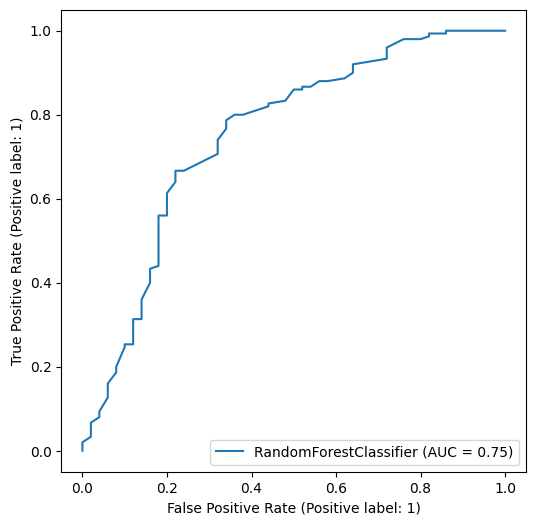

In [137]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6)) # modify figure size
RocCurveDisplay.from_estimator(model_tfidf, x_test_tfidf_b, y_test, ax = ax)

In [138]:
model_tfidf_importance = pd.Series(model_tfidf.feature_importances_,
                                   index=dict(sorted({v: k for k, v in vectorizer.vocabulary_.items()}.items())).values()).sort_values(ascending=False)
model_tfidf_importance

worst           0.010274
horrible        0.010116
made            0.009681
worse           0.009382
bleeding        0.009065
                  ...   
doryx           0.000000
passion         0.000000
dopaminergic    0.000000
pastry          0.000000
cyclen          0.000000
Length: 4506, dtype: float64

<Axes: >

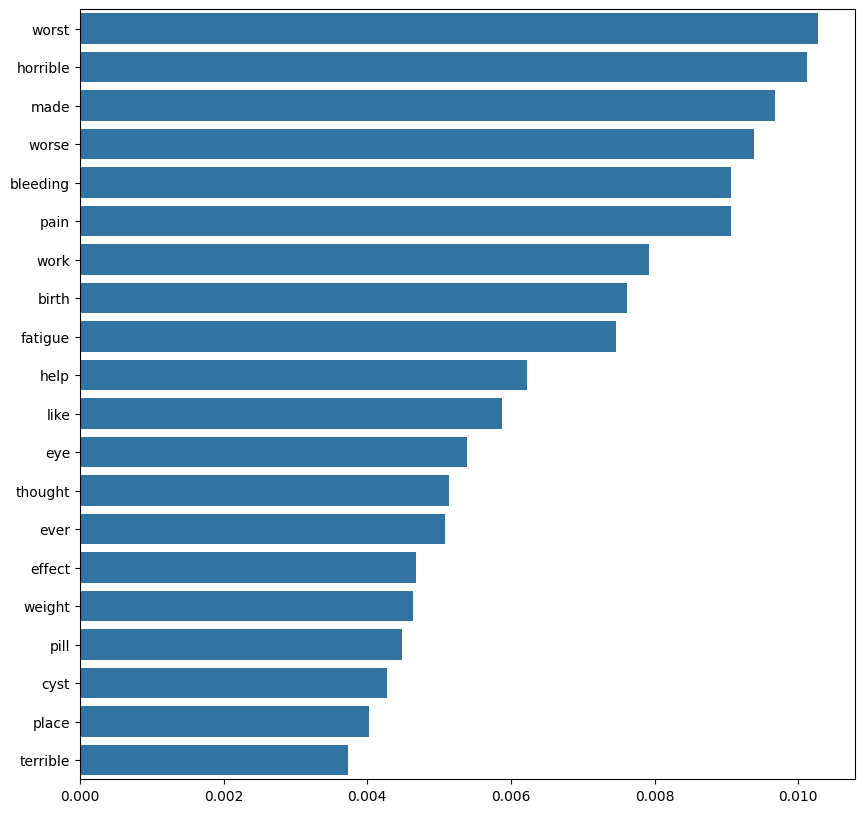

In [142]:
# show the 20 most influential word tokens
import seaborn as sns

plt.figure(figsize = (10, 10))
sns.barplot(data = model_tfidf_importance[:20], orient='h')

---

# 7. Extras: Using OpenAI to Embed the Text Data

It is also possible to utilise **external models** and resources to obtain rich text embeddings and vectorizations. Sometimes this could help because these external **large language models** were trained on a very large body of text with a vast amount of model weights using advanced NLP techniques. Note that these are usually **paid services**, but are available for free within a certain usage as a free trial. Here, we would use OpenAI's (developer of ChatGPT) [embeddings model](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings) to vectorize our data. However, note that in order to use their embeddings and run the code in this section, you have to have an [OpenAI account](https://platform.openai.com/signup) and obtain your own [OpenAI API key](https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key).

## 7.1 Connecting to the OpenAI Environment

In [144]:
# Install openai package firt.
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00


In [158]:
from openai import OpenAI

# Set up OpenAI API Key.
# **IMPORTANT: Be sure to replace this with your own key.**
openai_api_key = "Your_OpenAI_API_Key"

client = OpenAI(api_key=openai_api_key)

def get_openai_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

## 7.2. Apply OpenAI's Embeddings Model to the `review`s

In [ ]:
# Vectorise the `review` column, save it into a new column called `embedding`
# Note: this may take 15 mins or longer to run
df_train['embedding'] = df_train['review'].apply(get_openai_embedding)
df_test['embedding'] = df_test['review'].apply(get_openai_embedding)

df_train.to_csv(os.path.join(work_path, "train_ebd.csv"), index=False)
df_test.to_csv(os.path.join(work_path, "test_ebd.csv"), index=False)

df_train

In [ ]:
train_ebd = pd.read_csv(os.path.join(work_path, "train_ebd.csv"))
train_ebd['embedding'] = train_ebd.embedding.apply(eval).apply(np.array)

train_ebd = train_ebd[['pos_rating', 'embedding']]
train_ebd

,rating,embedding
0,0,"[-0.020021311938762665, -0.0066970461048185825..."
1,1,"[-0.03104434907436371, -0.010345912538468838, ..."
2,1,"[-0.009887202642858028, -0.0012491806410253048..."
3,1,"[-0.01926681026816368, 0.01790885627269745, 0...."
4,1,"[-0.04033423960208893, -0.005322061944752932, ..."
...,...,...
795,1,"[-0.012448159046471119, -0.00443376787006855, ..."
796,1,"[-0.03957827761769295, -0.015751084312796593, ..."
797,1,"[-0.03470670059323311, -0.013816523365676403, ..."
798,1,"[-0.012469958513975143, 0.014196568168699741, ..."


In [ ]:
test_ebd = pd.read_csv(os.path.join(work_path, "test_ebd.csv"))
test_ebd['embedding'] = test_ebd.embedding.apply(eval).apply(np.array)

test_ebd = test_ebd[['pos_rating', 'embedding']]
test_ebd

,rating,embedding
0,0,"[-0.016931885853409767, -0.0051310695707798, 0..."
1,1,"[-0.00980688538402319, 0.00024382547417189926,..."
2,0,"[-0.007015461102128029, 0.01202203519642353, 0..."
3,1,"[-0.011468385346233845, -0.028590109199285507,..."
4,1,"[0.007943474687635899, 0.0037498159799724817, ..."
...,...,...
195,1,"[-0.03534695506095886, -0.008992795832455158, ..."
196,1,"[-0.04101385176181793, 0.0009351476328447461, ..."
197,1,"[-0.016397397965192795, 0.019382361322641373, ..."
198,0,"[-0.00025293021462857723, 0.021311169490218163..."


In [ ]:
ratings = train_ebd.rating
train_ebd = train_ebd.embedding.apply(pd.Series)
train_ebd['pos_rating'] = ratings

train_ebd
# the final vector from OpenAI contained 1,536 features.
# Note that unlike TF-IDF, these features do not correspond to any particular
# word tokens. Thus, the usefulness of investigating feature importance in
# the final model is limited in this case.

,0,1,2,3,4,5,6,7,8,9,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,rating
0,-0.020021,-0.006697,0.033669,-0.018549,-0.018701,0.011528,-0.002480,-0.017749,-0.017723,-0.029175,...,-0.015083,0.021964,-0.028134,-0.007357,0.022332,-0.017216,-0.007205,-0.010982,-0.013356,0
1,-0.031044,-0.010346,0.008501,-0.020612,-0.011721,0.007397,-0.024196,-0.027131,-0.011780,-0.031335,...,-0.014134,0.048391,-0.032314,0.001023,0.009533,0.001683,0.001452,-0.019832,-0.027237,1
2,-0.009887,-0.001249,0.038061,-0.025458,-0.007244,0.020877,-0.022816,-0.047862,-0.025206,-0.019442,...,-0.019256,0.041355,-0.021169,-0.019509,0.002495,0.009323,-0.034077,0.022537,-0.011554,1
3,-0.019267,0.017909,0.017546,-0.046493,-0.015301,0.026608,-0.027589,-0.021418,-0.032026,0.011543,...,-0.011361,0.010655,-0.017062,0.006682,-0.022682,-0.030090,-0.012464,-0.011986,-0.024994,1
4,-0.040334,-0.005322,0.027250,-0.014337,-0.016342,0.009061,-0.022106,-0.049303,-0.018703,-0.015115,...,-0.004663,0.057296,-0.037037,-0.028332,-0.004607,-0.023900,-0.007729,-0.000958,-0.030046,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.012448,-0.004434,0.038986,-0.042787,-0.024224,0.034539,-0.020656,-0.046613,-0.020566,-0.020850,...,-0.006457,0.024534,-0.010703,0.006505,0.017140,-0.032394,0.003256,-0.017502,-0.042890,1
796,-0.039578,-0.015751,0.007909,-0.011873,-0.016888,0.013959,-0.040728,-0.032492,-0.037305,-0.014267,...,-0.019388,0.040701,-0.032090,0.000705,-0.000933,-0.021487,-0.000255,0.004820,-0.022758,1
797,-0.034707,-0.013817,0.012576,0.013219,-0.026183,-0.007010,-0.019185,-0.027608,-0.026335,0.007354,...,-0.032900,0.033409,-0.019847,-0.012811,0.010560,-0.019554,-0.018778,0.002094,-0.012226,1
798,-0.012470,0.014197,0.014911,-0.017994,-0.010995,0.009486,-0.006639,-0.044376,-0.024464,-0.039163,...,-0.017861,0.051044,-0.004882,-0.007826,0.003546,-0.015917,-0.029557,-0.007747,-0.003041,1


In [ ]:
ratings = test_ebd.rating
test_ebd = test_ebd.embedding.apply(pd.Series)
test_ebd['rating'] = ratings

test_ebd

,0,1,2,3,4,5,6,7,8,9,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,rating
0,-0.016932,-0.005131,0.002047,-0.013610,-0.013855,0.000470,-0.023524,-0.045066,-0.028250,-0.020563,...,-0.009953,0.043933,-0.010751,-0.011994,0.006312,-0.043624,0.008556,-0.009773,-0.050242,0
1,-0.009807,0.000244,0.012804,-0.002620,-0.025595,0.004499,-0.002824,-0.056099,-0.020880,-0.020149,...,-0.017616,0.033038,-0.030269,0.012993,0.006823,-0.032463,-0.003862,-0.005958,-0.028128,1
2,-0.007015,0.012022,0.037599,-0.029489,-0.035647,0.008280,-0.021941,-0.009331,-0.019926,-0.003395,...,-0.007466,0.022730,-0.017798,-0.006621,-0.000213,-0.023381,0.004159,-0.009043,-0.031617,0
3,-0.011468,-0.028590,0.043700,-0.012219,-0.015136,0.029030,-0.020026,-0.027348,-0.025123,-0.010013,...,-0.001472,0.037077,-0.011080,0.007387,0.005213,-0.029211,-0.008176,-0.005857,-0.019897,1
4,0.007943,0.003750,0.022022,-0.042348,-0.000971,0.022179,-0.031487,-0.035037,-0.011507,-0.017963,...,-0.012160,0.037779,-0.028275,0.005072,0.006103,-0.015430,-0.007017,0.005685,-0.016905,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.035347,-0.008993,0.019520,-0.012218,-0.013577,0.009454,-0.006155,-0.036283,-0.032356,-0.019416,...,-0.017205,0.037454,-0.028767,-0.019234,0.002074,-0.029833,-0.019494,-0.010144,-0.028715,1
196,-0.041014,0.000935,0.015533,-0.008363,-0.002192,0.003999,-0.030323,-0.030880,-0.015957,-0.005661,...,-0.011573,0.032763,-0.025375,-0.017151,-0.001643,-0.023040,-0.021435,0.003575,-0.028625,1
197,-0.016397,0.019382,0.014328,-0.032848,-0.012272,0.036085,-0.006003,-0.017897,-0.041710,-0.001211,...,-0.023482,0.034705,-0.024954,-0.003436,0.005625,-0.029744,-0.013134,-0.000661,-0.016822,1
198,-0.000253,0.021311,0.020982,-0.026066,-0.033192,0.011439,-0.008443,-0.040383,0.014383,0.007995,...,-0.011433,0.048207,-0.037828,-0.002386,-0.011472,-0.027080,-0.011571,0.008193,-0.019335,0


## 7.3. Model Development and Evaluation

In [ ]:
model_openai = RandomForestClassifier()

In [ ]:
X_train, y_train = train_ebd.loc[:, ~train_ebd.columns.isin(['rating'])], train_ebd['pos_rating']
print(X_train.shape, y_train.shape)

(800, 1536) (800,)


In [ ]:
X_test, y_test = test_ebd.loc[:, ~test_ebd.columns.isin(['rating'])], test_ebd['pos_rating']
print(X_test.shape, y_test.shape)

(200, 1536) (200,)


In [ ]:
model_openai.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = model_openai.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.24      0.39        50
           1       0.80      1.00      0.89       150

    accuracy                           0.81       200
   macro avg       0.90      0.62      0.64       200
weighted avg       0.85      0.81      0.76       200



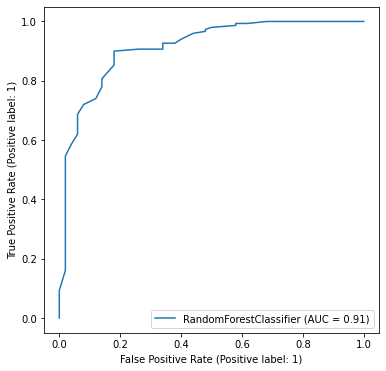

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6)) # modify figure size
RocCurveDisplay.from_estimator(model_openai, X_test, y_test, ax = ax)

A much better performance in terms of AUC!

---

# 8. Exercise

In the above sections, only the review data were used to build the model. But obviously, the `drugName` and `condition`, to some extent, also contain useful information, which might be useful to further improve the model's prediction performance. Thus, in this excercise, you are required to use `drugName`, `condition`, as well as embeddings from `review` data altogether to build a machine leaning model to predict the `rating`, and compare the performance of it with the model using only the `review` data (`model_tfidf`).

To begin, start by running codes in sections 1 and 2 to import the drug review dataset.

**Part 1**: Create a training and testing dataset that includes `drugName`, `condition`, `review`, and `rating`.

You are encouraged to start with a small portion of data, such as the 1,000 patients that I used in above sections, because the more data is used, the more computation time is required.

In [ ]:
## YOUR CODE HERE ##

# hint: refer to section 3 above.
# Include more columns in df_train rather than just 'review' and 'rating'.
# Concatenate columns you choose to generate a new column.

**Part 2**: Use TF-IDF or OpenAI embedding method to vectorize the new generated column.

If you choose to use the OpenAI embedding method, please don't include too much data. Otherwise, it will take a long time to get the embedding data from OpenAI.

In [ ]:
## YOUR CODE HERE ##

# hint: refer to either section 4, 5 or 7 above.

**Part 4**: Define a Random Forest Classifier and train the model.

You may use any other models you want to try, including the models you learnt from this class or other models you learnt elsewhere.


In [ ]:
## YOUR CODE HERE ##

# hint: refer to section 6 above.

**Part 5**: Test the model on test dataset and compare the performance with the models with just review data.


In [ ]:
## YOUR CODE HERE ##

# hint: refer to section 6 above.